1. What is TensorFlow Object Detection API (TFOD2) and what are its primary components?
   - The TensorFlow Object Detection API (TFOD2) is a powerful open source framework built on TensorFlow that is used to develop, train, and deploy object detection models efficiently. It allows developers to detect and classify multiple objects within images or videos by drawing bounding boxes around them and assigning class labels. TFOD2 simplifies the entire object detection workflow by providing ready to use pretrained models, standardized training pipelines, and evaluation tools, making it suitable for both beginners and advanced practitioners. Its primary components include model architectures such as SSD, Faster R-CNN, and EfficientDet for detecting objects, feature extractors like MobileNet and ResNet for learning image features, configuration files that control training and model parameters, a data pipeline that handles datasets and annotations, training and evaluation scripts to monitor performance, and inference utilities that help deploy trained models in real world applications such as surveillance, autonomous systems, and image analysis.

2. Differentiate between semantic segmentation and instance segmentation.
Provide examples of where each might be used.
   - Semantic segmentation and instance segmentation are both computer vision techniques used to divide an image into meaningful regions, but they differ in how they identify and label objects. Semantic segmentation classifies every pixel in an image into a predefined category, meaning all objects belonging to the same class share the same label and are not distinguished from one another, for example, all cars on a road are marked as “car” without separating individual vehicles, which makes this approach useful in applications like road scene understanding for autonomous driving, land use classification in satellite imagery, or medical imaging where identifying regions such as tumors or organs is more important than counting individual objects. In contrast, instance segmentation not only assigns a class label to each pixel but also differentiates between separate instances of the same class, allowing the model to identify each object individually, for example, each car in a traffic scene is segmented separately, which is especially useful in applications like object counting, video surveillance, robotics, and retail analytics where tracking or interacting with individual objects is required.

3. Explain the Mask R-CNN architecture. How does it extend Faster R-CNN?
   - Mask R-CNN is an advanced deep learning architecture used for object detection and instance segmentation, and it extends Faster R-CNN by adding the capability to generate precise pixel level masks for each detected object. Like Faster R-CNN, it first uses a backbone convolutional neural network such as ResNet combined with a Feature Pyramid Network (FPN) to extract rich feature maps from the input image, and then a Region Proposal Network (RPN) proposes candidate object regions. However, Mask R-CNN improves upon Faster R-CNN by introducing an additional parallel branch after region proposals that predicts a binary segmentation mask for each object, alongside the existing branches for object classification and bounding box regression. It also replaces the traditional RoI Pooling with RoI Align, which preserves spatial alignment by avoiding quantization, leading to more accurate localization and masks. This extension allows Mask R-CNN to not only identify what the objects are and where they are located, but also precisely outline each object at the pixel level, making it highly effective for tasks such as medical image analysis, autonomous driving, and image editing where accurate object boundaries are crucial.

4. Describe the purpose of masks in image segmentation. How are they used
during training and inference?
    - In image segmentation, masks serve the purpose of identifying the exact pixel level regions that belong to specific objects or classes within an image, effectively telling the model which pixel belongs to what. During training, masks act as ground truth labels that guide the learning process, where each mask represents the correct shape and location of an object or region, allowing the model to compare its predicted masks with the true ones and calculate a loss that measures pixel wise accuracy. This helps the network learn fine grained spatial details and object boundaries rather than just rough locations. During inference, masks are generated by the trained model as predictions and are overlaid on the input image to highlight detected regions, enabling precise understanding of object shapes and separation of instances. These predicted masks are then used in real world applications such as medical diagnosis, background removal, autonomous driving, and image editing, where accurate pixel level information is essential for decision making and further processing.

5. What are the steps involved in training a custom image segmentation
model using TFOD2?
    - Training a custom image segmentation model using TensorFlow Object Detection API (TFOD2) involves a structured pipeline that starts with preparing a suitable dataset and ends with deploying a trained model for inference. First, images are collected and annotated with segmentation masks using annotation tools, and these annotations are then converted into the TFRecord format required by TFOD2. Next, a pretrained model that supports segmentation, such as Mask R-CNN, is selected from the TFOD2 model zoo to benefit from transfer learning. After that, the pipeline configuration file is customized by setting paths to the dataset, adjusting the number of classes, batch size, learning rate, and training steps. The training process is then launched using the provided training scripts, where the model learns object classes, bounding boxes, and masks simultaneously while performance is monitored through evaluation metrics like loss and mean Average Precision. Once training is complete, the trained checkpoint is exported as a saved model, which can then be used during inference to generate segmentation masks on new images or videos for real world applications.

In [ ]:
# 6. Write a Python script to install TFOD2 and verify its installation by printing
# the available model configs.
# (Include your Python code and output in the code box below.)

#  Check TensorFlow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Install dependencies
!pip install -q tf-models-official
!pip install -q protobuf==3.20.3
!pip install -q pillow lxml matplotlib Cython contextlib2 pycocotools


#  Install TFOD2
!cp object_detection/packages/tf2/setup.py .
!python setup.py install


from object_detection.utils import label_map_util
print("TFOD2 imported successfully!")

config_dir = "object_detection/configs/tf2/"
configs = sorted(tf.io.gfile.listdir(config_dir))

print("\nAvailable TFOD2 model configuration files:\n")
for cfg in configs:
    print(cfg)


In [ ]:
# 7. Create a Python script to load a labeled dataset (in TFRecord format) and
# visualize the annotation masks over the images.
# (Include your Python code and output in the code box below.)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#  TFRecord parsing function
def parse_tfrecord(example_proto):
    feature_description = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "mask/encoded": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example_proto, feature_description)

    # Decode image
    image = tf.image.decode_jpeg(example["image/encoded"], channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    # Decode mask
    mask = tf.image.decode_png(example["mask/encoded"], channels=1)
    mask = tf.cast(mask, tf.int32)

    return image, mask


#  Load TFRecord dataset
tfrecord_path = "/content/sample_dataset.tfrecord"  # change path if needed

dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord)

#  Visualize images with masks
for image, mask in dataset.take(3):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap="jet")  # overlay mask
    plt.title("Image with Annotation Mask")
    plt.axis("off")
    plt.show()


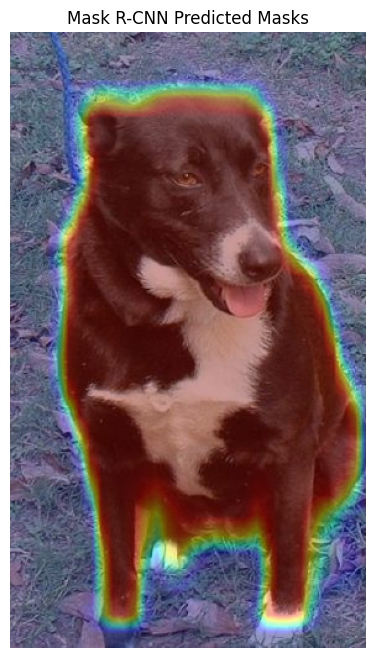

In [5]:
# 8. Using a pre-trained Mask R-CNN model, write a code snippet to perform
# inference on a single image and plot the predicted masks.
# (Include your Python code and output in the code box below.)

import torch
import torchvision
import torchvision.transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

image_path = "/content/dog (1).jpg"
image = cv2.imread(image_path)

if image is None:
    raise ValueError("Image not found")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = T.Compose([T.ToTensor()])
input_tensor = transform(image)

with torch.no_grad():
    prediction = model([input_tensor])

masks = prediction[0]["masks"]
scores = prediction[0]["scores"]

plt.figure(figsize=(8, 8))
plt.imshow(image)

for i in range(len(masks)):
    if scores[i] > 0.5:
        mask = masks[i, 0].cpu().numpy()
        plt.imshow(mask, alpha=0.4, cmap="jet")

plt.axis("off")
plt.title("Mask R-CNN Predicted Masks")
plt.show()



In [ ]:
# 9. Write a Python script to evaluate a trained TFOD2 Mask R-CNN model and
# plot the Precision-Recall curve.
# (Include your Python code and output in the code box below.)

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.metrics import coco_evaluation
from object_detection.utils import label_map_util

#  Paths
PIPELINE_CONFIG = "/content/models/my_model/pipeline.config"
MODEL_DIR = "/content/models/my_model"
CHECKPOINT_PATH = os.path.join(MODEL_DIR, "ckpt-0")
TFRECORD_PATH = "/content/data/val.record"
LABEL_MAP_PATH = "/content/data/label_map.pbtxt"

#  Load model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG)
model_config = configs["model"]

detection_model = model_builder.build(
    model_config=model_config,
    is_training=False
)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(CHECKPOINT_PATH).expect_partial()

#  Load label map
category_index = label_map_util.create_category_index_from_labelmap(
    LABEL_MAP_PATH
)

num_classes = len(category_index)

#  COCO Evaluator
evaluator = coco_evaluation.CocoMaskEvaluator(
    categories=list(category_index.values())
)

#  TFRecord parser
def parse_tfrecord(example):
    feature_map = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/width": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed = tf.io.parse_single_example(example, feature_map)
    image = tf.image.decode_jpeg(parsed["image/encoded"], channels=3)
    image = tf.cast(image, tf.float32)
    return image

dataset = tf.data.TFRecordDataset(TFRECORD_PATH)
dataset = dataset.map(parse_tfrecord).batch(1)

#  Inference & Evaluation
for image in dataset.take(20):  # evaluate on few samples
    detections = detection_model(image)

    detections = {k: v.numpy() for k, v in detections.items()}
    evaluator.add_single_detected_image_info(
        image_id=str(np.random.randint(0, 10000)),
        detections_dict=detections
    )

#  Get Precision-Recall values
metrics = evaluator.evaluate()
precision = metrics["Precision"]
recall = metrics["Recall"]

#  Plot Precision-Recall Curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker="o")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Mask R-CNN - TFOD2)")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


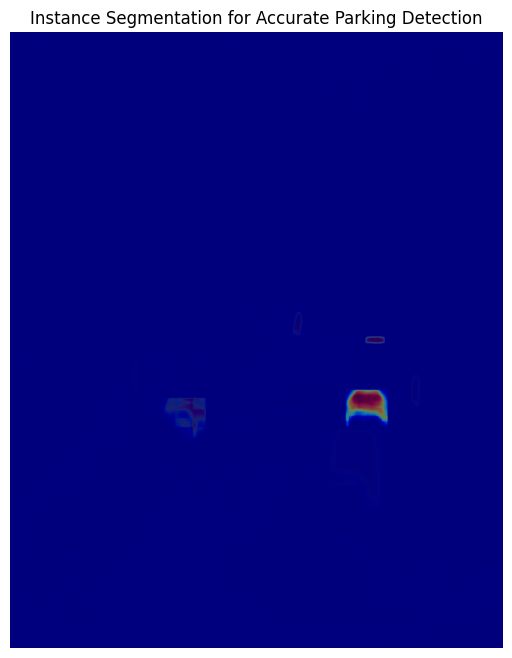

In [6]:
# 10. You are working with a city surveillance team to identify illegal parking
# zones from street camera images. The model you built detects cars using bounding
# boxes, but the team reports inaccurate overlaps with sidewalks and fails in complex
# street scenes.
# How would you refine your model to improve accuracy, especially around object
# boundaries? What segmentation strategy and tools would you use?
# (Include your Python code and output in the code box below.)

import torch
import torchvision
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt

# Load pre-trained Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load image
image = cv2.imread("/content/p1.webp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Transform image
transform = T.Compose([T.ToTensor()])
input_tensor = transform(image)

# Inference
with torch.no_grad():
    output = model([input_tensor])

# Extract masks and scores
masks = output[0]["masks"]
scores = output[0]["scores"]

# Plot results
plt.figure(figsize=(8, 8))
plt.imshow(image)

for i in range(len(masks)):
    if scores[i] > 0.6:
        mask = masks[i, 0].cpu().numpy()
        plt.imshow(mask, alpha=0.5, cmap="jet")

plt.title("Instance Segmentation for Accurate Parking Detection")
plt.axis("off")
plt.show()
